# Random Forest - an ensemble learner built on decision trees

## Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

We randomize our tree building by
(1) randomize data selection 
(2) randomize the selected features

```python
class sklearn.ensemble.RandomForestRegressor(n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)
```

**n_estimator parameter**: number of trees we want to build.

**criterion:** The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error.

**max_features parameter**:
Decision trees and trees in the random forest algorithm differ on one important aspect. In random forest trees we focus on a randomly selected subset of the features and find the best split within this subset. The number of features in the subset that are randomly considered at each stage is controlled by the max_features parameter. 

int, float, string or None, optional (default=”auto”)

    The number of features to consider when looking for the best split:

        If int, then consider max_features features at each split.
        If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
        If “auto”, then max_features=n_features.
        If “sqrt”, then max_features=sqrt(n_features).
        If “log2”, then max_features=log2(n_features).
        If None, then max_features=n_features.

    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

**min_impurity_decrease:** float, optional (default=0.)

    A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    
**Bootstrap sampling**: Sampling with replacement, bootstrap samples are used to create dataset rows.Also called **bagging**.

    boolean, optional (default=True)

    Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

**oob_score:** bool, optional (default=False)

    whether to use out-of-bag samples to estimate the R^2 on unseen data.

source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

## Predicting Temperature with Random Forest: Given a year of data, can we predict tomorrow's maximum temperature?

#### 1. Read the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('temps.csv')
df.head()

,year,month,day,week,temp_2,temp_1,average,actual
0,2016,1,1,Fri,45,45,45.6,45
1,2016,1,2,Sat,44,45,45.7,44
2,2016,1,3,Sun,45,44,45.8,41
3,2016,1,4,Mon,44,41,45.9,40
4,2016,1,5,Tues,41,40,46.0,44


#### 2. Explore the data

In [3]:
df.shape

(348, 8)

In [4]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.511494,62.560345,59.760632,62.543103
std,0.0,3.498380,8.772982,11.813019,11.767406,10.527306,11.794146
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000
max,2016.0,12.000000,31.000000,92.000000,92.000000,77.400000,92.000000


#### 3. Change the categorical data to binary "One-Hot Encoding"

Weekdays are represented by name, but random forest likes numbers! Converting day of the week to binary: 

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |


| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [5]:
# One-hot encode categorical features
df = pd.get_dummies(df)
df.head()

,year,month,day,temp_2,temp_1,average,actual,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,0,0,0,0,0,1,0


#### 4. Create additional features

In [6]:
season = []
for month in df['month']:
    if month in [1,2,12]: season.append('winter')
    if month in [3,4,5]:season.append('spring')
    if month in [6,7,8]:season.append('summer')
    if month in [9,10,11]: season.append('fall')

In [7]:
season[:5]

['winter', 'winter', 'winter', 'winter', 'winter']

In [8]:
df['season'] = season

In [9]:
df.head()

,year,month,day,temp_2,temp_1,average,actual,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed,season
0,2016,1,1,45,45,45.6,45,1,0,0,0,0,0,0,winter
1,2016,1,2,44,45,45.7,44,0,0,1,0,0,0,0,winter
2,2016,1,3,45,44,45.8,41,0,0,0,1,0,0,0,winter
3,2016,1,4,44,41,45.9,40,0,1,0,0,0,0,0,winter
4,2016,1,5,41,40,46.0,44,0,0,0,0,0,1,0,winter


#### 5. Pair Plots to observe the relationship between variables

Pairplots show all the relationships between variables in a dataset; showing which variables are highly correlated.
Our assumption is variables that are more correlated with temp_1 (max temperature) would be more useful for predicting the actuals. 

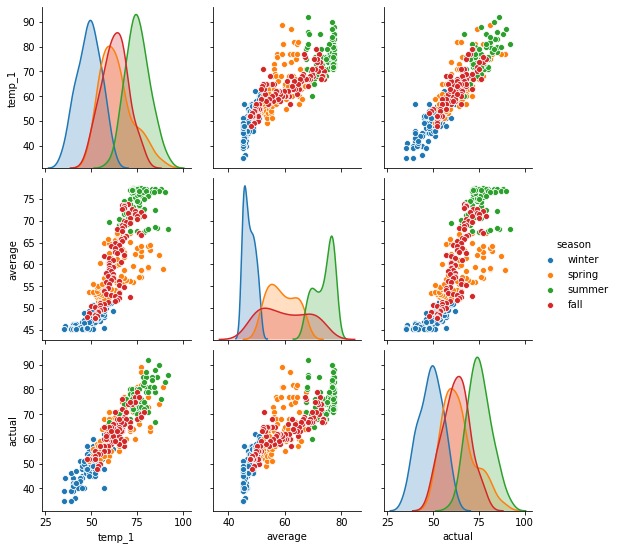

In [10]:
import seaborn as sns
sns.pairplot(df[['temp_1','average','actual','season']],hue='season',diag_kind='kde')

In [11]:
df = pd.get_dummies(df)
df.head()

,year,month,day,temp_2,temp_1,average,actual,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed,season_fall,season_spring,season_summer,season_winter
0,2016,1,1,45,45,45.6,45,1,0,0,0,0,0,0,0,0,0,1
1,2016,1,2,44,45,45.7,44,0,0,1,0,0,0,0,0,0,0,1
2,2016,1,3,45,44,45.8,41,0,0,0,1,0,0,0,0,0,0,1
3,2016,1,4,44,41,45.9,40,0,1,0,0,0,0,0,0,0,0,1
4,2016,1,5,41,40,46.0,44,0,0,0,0,0,1,0,0,0,0,1


#### 6. Creating the X & y

In [12]:
y = df['actual']
X = df.drop('actual',axis = 1)

In [13]:
features = list(X.columns)

#### 7. Training and Testing Sets

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [15]:
X_train.shape,X_test.shape

((261, 17), (87, 17))

#### 8. Create a random forest regressor, train and predict

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000,random_state=42)
rf.fit(X_train,y_train)
predictions=rf.predict(X_test)

#### Interpretting the results:

#### 9. Review performance metrics: MAE and accuracy

In [17]:
import numpy as np
# Calculate the absolute errors
error = abs(predictions-y_test)

# Calculate the mean absolute error (mae)
mae = error.mean()
print ('Mean absolute error',mae)

# Calculate mean absolute percentage error (MAPE)
MAPE = (error/y_test)*100

# Calculate and display accuracy
accuracy = 100 - MAPE.mean()

print('Accuracy:', round(accuracy, 2), '%.')

Mean absolute error 3.9029885057471265
Accuracy: 93.88 %.


#### 10. Comparison to the average temperature

We can compare the model results to the average temperature as a way of finding how good our model is.

In [20]:
baseline_pred = X_test['average']
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline error: ', round(baseline_errors.mean(), 2), 'degrees.')

Average baseline error:  5.06 degrees.


Compared to the average temperature that has an error of 5 degrees, our model has an error of 3.93 degrees.

#### Variable Importances

In [21]:
for f in range(len(features)): 
    print('Variable: {:20} Importance: {}'.format(features[f],round(rf.feature_importances_[f],2)))

Variable: year                 Importance: 0.0
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.03
Variable: temp_2               Importance: 0.03
Variable: temp_1               Importance: 0.7
Variable: average              Importance: 0.2
Variable: week_Fri             Importance: 0.01
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.01
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0
Variable: season_fall          Importance: 0.0
Variable: season_spring        Importance: 0.0
Variable: season_summer        Importance: 0.0
Variable: season_winter        Importance: 0.0


----

## Cross-validation (CV)
The training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

        A model is trained using k - 1 of the folds as training data; the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.


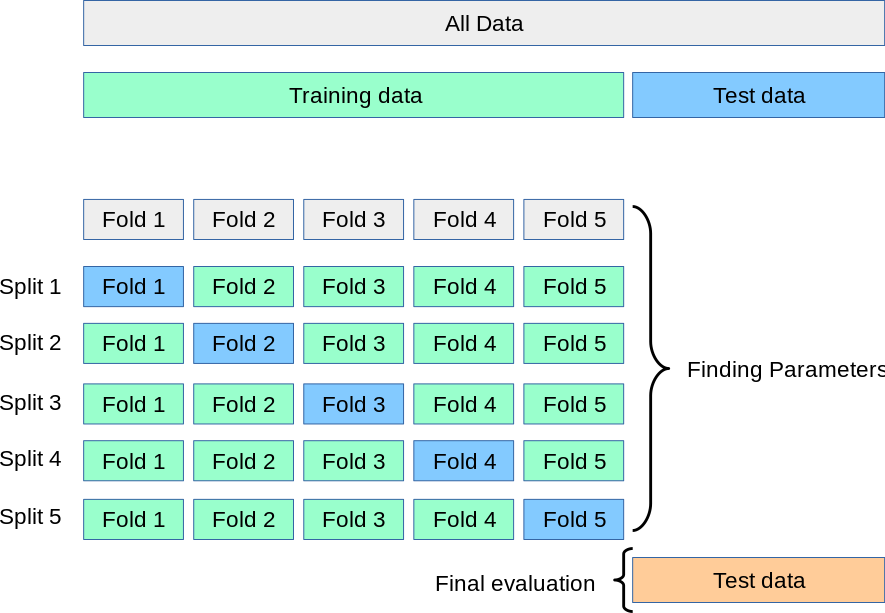(attachment:grid_search_cross_validation.png)

## RandomizedSearchCV
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Randomized search on hyper parameters.

RandomizedSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In [24]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(20,2000,10)]

# Number of features to consider at every split
max_features = ['auto','sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10,100,10)]

# Minimum number of samples required to split a node
min_samples_split = [2,5,10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]

# Method of selecting samples for training each tree
bootstrap = [True,False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, scoring = 'neg_mean_absolute_error',
                              cv=3,verbose=2,random_state=42)

# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, total=   0.0s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, total=   0.0s
[CV] n_estimators=240, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  n_estimators=240, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.4s
[CV] n_estimators=240, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=240, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.3s
[CV] n_estimators=240, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=240, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.4s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, total=   2.3s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False 
[CV]  n_estimators=2000, mi

[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total=   3.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total=   4.6s
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=460, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   1.2s
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=460, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   1.0s
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=460, min_sa

[CV]  n_estimators=1560, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False, total=   3.2s
[CV] n_estimators=240, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True 
[CV]  n_estimators=240, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True, total=   0.5s
[CV] n_estimators=240, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True 
[CV]  n_estimators=240, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True, total=   0.5s
[CV] n_estimators=240, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True 
[CV]  n_estimators=240, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True, total=   0.5s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=2000, min_samp

[CV]  n_estimators=1340, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   1.8s
[CV] n_estimators=1340, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=1340, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   1.9s
[CV] n_estimators=1340, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=1340, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   1.9s
[CV] n_estimators=1340, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True 
[CV]  n_estimators=1340, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=   2.3s
[CV] n_estimators=1340, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True 
[CV]  n_estimat

[CV]  n_estimators=1560, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, total=   3.6s
[CV] n_estimators=1560, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=1560, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, total=   2.9s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   0.0s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   0.0s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=20, min_samples_

[CV]  n_estimators=240, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.5s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   1.4s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   1.5s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   1.5s
[CV] n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=680, min_sample

[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   1.0s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   1.1s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   1.0s
[CV] n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   1.4s
[CV] n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=680, min_

[CV]  n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, total=   1.3s
[CV] n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, total=   1.3s
[CV] n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, total=   1.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   2.5s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, 

[CV]  n_estimators=900, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=True, total=   1.7s
[CV] n_estimators=900, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=True 
[CV]  n_estimators=900, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=True, total=   1.7s
[CV] n_estimators=1560, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1560, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=   2.7s
[CV] n_estimators=1560, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1560, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=   2.8s
[CV] n_estimators=1560, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1560

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  9.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [27]:
# show the best parameters!

rf_random.best_params_

{'n_estimators': 1560,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

### How to evaluate the models?
#### Use an Evaluation Function

In [28]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [30]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(rf,param_grid)

In [31]:
# Evaluating the default model
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
base_model.fit(X_train, y_train)
evaluate(base_model, X_test, y_test)

# Evaluate the best random search model
best_random = rf_random.best_estimator_
evaluate(best_random,X_test,y_test)

Model Performance
Average Error: 3.9030 degrees.
Accuracy = 93.88%.
Model Performance
Average Error: 3.8355 degrees.
Accuracy = 93.99%.


## Grid Search

In [32]:
# Fit the grid search to the training data

grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [33]:
# show the best parameters
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [34]:
# what is the best estimator?
best_grid = grid_search.best_estimator_

# check the model performance:
evaluate(best_grid, X_test,y_test )

Model Performance
Average Error: 3.6233 degrees.
Accuracy = 94.33%.


**Random Forest Regressor Example Completed.**